In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from flows import Flow
from flows.affine import Planar, Radial
tfd = tfp.distributions

In [2]:
k = 8
n_layers = 5
transform = Planar(k)
for i in range(n_layers):
    transform = Planar(k)(transform)

In [3]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros((k,)))

In [4]:
flow = Flow(transform)

In [5]:
x1_samples = tfd.Normal(loc=2.0, scale=4).sample(10000)
x2_samples = tfd.Normal(loc=0.5*x1_samples**2.0, scale=2.0*tf.ones(x1_samples.shape)).sample()
x_samples = tf.stack([x2_samples, x1_samples], axis=1)

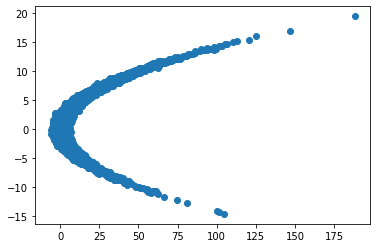

In [6]:
plt.scatter(x_samples[:,0], x_samples[:,1])

tfp.distributions.TransformedDistribution("chain_of_Planar_of_PlanarMultivariateNormalDiag/", batch_shape=[], event_shape=[8], dtype=float32)


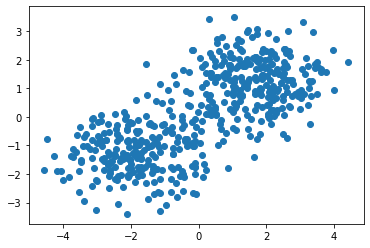

In [7]:
flow_dist = flow.transform(base_dist)
print(flow_dist)
flow_dist_samples = flow_dist.sample(512)
plt.scatter(flow_dist_samples[:,0], flow_dist_samples[:,1])

In [16]:
def build_encoder(input_dims, flow, hidden_units=8):
    from tensorflow.keras.layers import Lambda
    input_0 = Input(input_dims)
    linearh = lambda x: Dense(hidden_units, activation='relu')(x)
    h = linearh(linearh(input_0))
    mus = Dense(hidden_units)(h)
    sigmas = Dense(hidden_units)(h)
    flow_params = Dense(flow.amortized_params, activation='linear')(h)
    sample = Lambda(lambda args: tf.random.normal((hidden_units,), args[0], args[1]))
    def flow_z(args):
        z, params = args
        flow.amortize(tf.reshape(params, (n_layers, flow.amortized_parasm // n_layers)))
        return flow.transform.forward(z)
    z_0 = sample([mus, sigmas])
    z_k = Lambda(flow_z)(z_0)
    return Model(inputs=input_0, outputs=z_k)

def build_decoder(output_dims, hidden_units=8):
    input_0 = Input(hidden_units)
    linearh = lambda x: Dense(hidden_units, activation='relu')(x)
    h_out = linearh(linearh(input_0))
    output_0 = Dense(output_dims)(h_out)
    return Model(inputs=input_0, outputs=output_0)

In [ ]:
encoder = build_encoder(2, flow)
decoder = build_decoder(2)

In [12]:
model = Model(inputs=encoder.inputs, outputs=decoder(encoder(encoder.inputs)))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [13]:
model.fit(x_samples, x_samples, epochs=20)

Train on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 72us/sample - loss: 7.9891
Epoch 2/20
10000/10000 [==============================] - 0s 38us/sample - loss: 8.5192
Epoch 3/20
10000/10000 [==============================] - 0s 36us/sample - loss: 3.5776
Epoch 4/20
10000/10000 [==============================] - 0s 39us/sample - loss: -3.9795
Epoch 5/20
10000/10000 [==============================] - 0s 36us/sample - loss: -5.0299
Epoch 6/20
10000/10000 [==============================] - 0s 38us/sample - loss: -5.2247
Epoch 7/20
10000/10000 [==============================] - 0s 37us/sample - loss: -6.2585
Epoch 8/20
10000/10000 [==============================] - 0s 46us/sample - loss: -6.5890
Epoch 9/20
10000/10000 [==============================] - 0s 40us/sample - loss: -6.5315
Epoch 10/20
10000/10000 [==============================] - 0s 43us/sample - loss: -6.1680
Epoch 11/20
10000/10000 [==============================] - 0s 41us/sample - loss: -5.8961

In [14]:
model_samples = model.predict(x_samples)